### Dynamics of microbial OTUs

In this notebook we use the multivariate AR(1) model to fit a multivariate time series of marine bacterial operational taxonomic units (OTUs).
The dataset comes from

*Martin-Platero et al. 2018. High resolution time sereis reveals cohesive but short lived communities in coastal plankton. Nature Communications*

First load packages and read in the dataset:

In [99]:
using StanSample, Statistics, PyPlot, CSV, DataFrames, LinearAlgebra

In [5]:
DAT = CSV.read("data/bacterial_OTU.csv");

In [78]:
phyla = unique(DAT[:,3])
PHY = zeros(length(phyla),size(DAT[:,9:end],2))
for i in 1:length(phyla)
    PHY[i,:] = Matrix(aggregate(DAT[findall(x -> x == phyla[i], DAT.phylum),9:end],sum))
end
PHY = hcat(phyla,PHY)
PHY_sum = convert(DataFrame,hcat(phyla,sum(PHY[:,2:end],dims=2)))
sort!(PHY_sum,:x2,rev=true)

,x1,x2
,Any,Any
1,p__Proteobacteria,1.08697e6
2,p__Bacteroidetes,1.06803e6
3,p__,245003.0
4,p__Cyanobacteria,225623.0
5,p__Verrucomicrobia,86525.0
6,p__Planctomycetes,65740.0
7,p__Actinobacteria,55012.0
8,p__Firmicutes,27331.0
9,p__Fusobacteria,10889.0


In [97]:
phy = zeros(4,size(PHY,2)-1)
for i in 1:4
    phy[i,:] = PHY[findall(x->x==PHY_sum[i,1],PHY)[1][1],2:end]
end
    

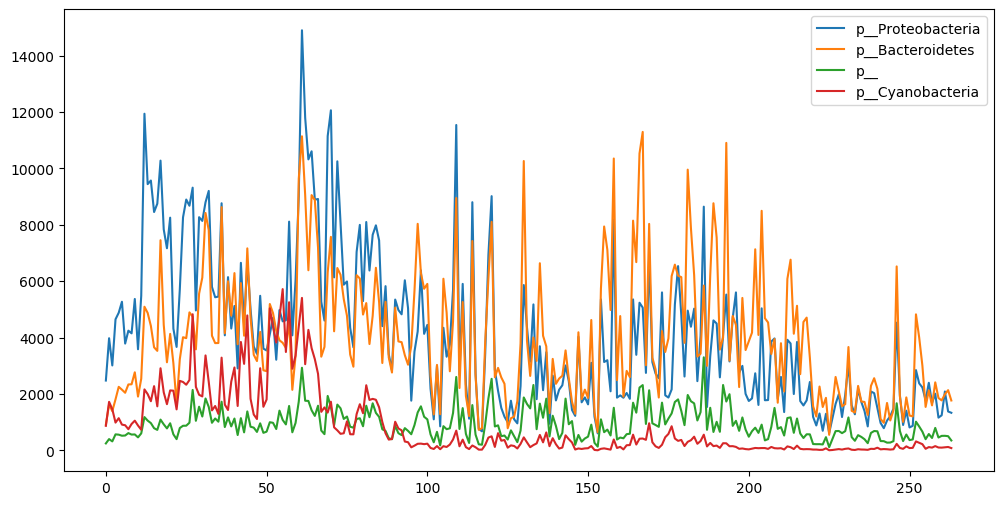

In [102]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(transpose(phy))
ax.legend(PHY_sum[1:4,1]);

In [103]:
mod_code = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    Y[,1] ~ normal(init, sigma);            //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma);  //conditional predictive distribution
    }
}";

In [104]:
dat_PHY = Dict("T" => size(phy,2),"p" => size(phy,1), "Y" => phy)

Dict{String,Any} with 3 entries:
  "Y" => [2476.0 3977.0 … 1379.0 1333.0; 913.0 1626.0 … 2135.0 1769.0; 246.0 40…
  "T" => 264
  "p" => 4

In [105]:
sm = SampleModel("MV_AR_OTU", mod_code)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_y9Uz2K/MV_AR_OTU.stan updated.


  name =                    "MV_AR_OTU"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_y9Uz2K"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [106]:
(sample_file, log_file) = stan_sample(sm, data=dat_PHY, n_chains = 4);

In [107]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×31×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.4.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.4.2, PHI.1.3, PHI.2.3, PHI.3.3, PHI.4.3, PHI.1.4, PHI.2.4, PHI.3.4, PHI.4.4, sigma.1, sigma.2, sigma.3, sigma.4, init.1, init.2, init.3, init.4

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean       │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64    │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼────────────┼───────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.780824   │ 0.0905022 │ 0.00143096  │ 0.00109639  │
│ 2   │ PHI.2.1    │ 0.0302101  │ 0.0909383 │ 0.00143786  │ 0.00132776  │
│ 3   │ PHI.3.1    │ 0.00142678 │ 0.

In [108]:
ESS = ess(chns)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 4822.02 │ 0.999464 │
│ 2   │ PHI.2.1    │ 4815.98 │ 0.999517 │
│ 3   │ PHI.3.1    │ 4933.9  │ 0.999344 │
│ 4   │ PHI.4.1    │ 5339.39 │ 0.999863 │
│ 5   │ PHI.1.2    │ 5008.19 │ 0.999939 │
│ 6   │ PHI.2.2    │ 5136.52 │ 0.99962  │
│ 7   │ PHI.3.2    │ 5554.2  │ 0.999387 │
│ 8   │ PHI.4.2    │ 5464.61 │ 0.999931 │
│ 9   │ PHI.1.3    │ 4909.19 │ 0.999471 │
│ 10  │ PHI.2.3    │ 5576.98 │ 0.999607 │
│ 11  │ PHI.3.3    │ 4897.46 │ 0.999602 │
│ 12  │ PHI.4.3    │ 5247.86 │ 0.99946  │
│ 13  │ PHI.1.4    │ 4880.01 │ 0.999511 │
│ 14  │ PHI.2.4    │ 5534.59 │ 0.999629 │
│ 15  │ PHI.3.4    │ 5094.58 │ 0.999589 │
│ 16  │ PHI.4.4    │ 5376.73 │ 1.00007  │
│ 17  │ sigma.1    │ 6678.11 │ 0.999782 │
│ 18  │ sigma.2    │ 6687.77 │ 0.999313 │
│ 19  │ sigma.3    │ 6876.37 │ 0.999269 │
│ 20  │ sigma.4    │ 7199.72 │ 0.999433 │
│ 21  │ init.1     │ 7217.8  